<a href="https://colab.research.google.com/github/olivia-sp/study-pjt/blob/main/CRAFT_license_plate_data_fine_tuning_v0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install this package to use Colab's GPU for training
!apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

In [ ]:
!pip install keras-ocr

     |████████████████████████████████| 61kB 3.0MB/s 
     |████████████████████████████████| 9.5MB 7.6MB/s 
     |████████████████████████████████| 860kB 43.1MB/s 
     |████████████████████████████████| 133kB 53.3MB/s 
     |████████████████████████████████| 51kB 5.4MB/s 
  Created wheel for keras-ocr: filename=keras_ocr-0.8.6-cp37-none-any.whl size=42937 sha256=ee6b4c9ee62080412ec7fe51db5f312e9e79b84474561abf0342ca451a3630a1
  Stored in directory: /root/.cache/pip/wheels/79/59/e6/79dd15333b911d51ea68d7e4c325e14f042eacc141201dca44
Successfully built keras-ocr


In [ ]:
data_dir = '.'

import os
import math
import imgaug
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import tensorflow as tf

import keras_ocr

dataset = keras_ocr.datasets.get_icdar_2013_detector_dataset(
    cache_dir='.',
    skip_illegible=False
)

Looking for ./icdar2013/Challenge2_Training_Task12_Images.zip
Looking for ./icdar2013/Challenge2_Training_Task2_GT.zip


In [ ]:
dataset

[('./icdar2013/Challenge2_Training_Task12_Images/135.jpg',
  [[(array([[ 19, 117],
            [117, 117],
            [117, 305],
            [ 19, 305]]), 'J'), (array([[134, 113],
            [277, 113],
            [277, 303],
            [134, 303]]), '2'), (array([[283, 113],
            [448, 113],
            [448, 306],
            [283, 306]]), 'S'), (array([[460, 119],
            [595, 119],
            [595, 302],
            [460, 302]]), 'E')], [(array([[  0, 387],
            [282, 387],
            [282, 479],
            [  0, 479]]), '')], [(array([[340, 387],
            [639, 387],
            [639, 479],
            [340, 479]]), '')]],
  1),
 ('./icdar2013/Challenge2_Training_Task12_Images/258.jpg',
  [[(array([[ 81,  89],
            [112,  89],
            [112, 167],
            [ 81, 167]]), 'F'), (array([[120,  90],
            [138,  90],
            [138, 169],
            [120, 169]]), 'I'), (array([[141,  91],
            [197,  91],
            [197, 17

In [ ]:
train, validation = sklearn.model_selection.train_test_split(
    dataset, train_size=0.8, random_state=42
)
augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.Affine(
    scale=(1.0, 1.2),
    rotate=(-5, 5)
    ),
    imgaug.augmenters.GaussianBlur(sigma=(0, 0.5)),
    imgaug.augmenters.Multiply((0.8, 1.2), per_channel=0.2)
])
generator_kwargs = {'width': 640, 'height': 640}
training_image_generator = keras_ocr.datasets.get_detector_image_generator(
    labels=train,
    augmenter=augmenter,
    **generator_kwargs
)
validation_image_generator = keras_ocr.datasets.get_detector_image_generator(
    labels=validation,
    **generator_kwargs
)

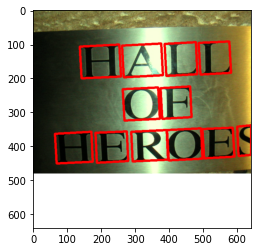

In [ ]:
image, lines, confidence = next(training_image_generator)
canvas = keras_ocr.tools.drawBoxes(image=image, boxes=lines, boxes_format='lines')
plt.imshow(canvas)

In [ ]:
detector = keras_ocr.detection.Detector()

batch_size = 1
training_generator, validation_generator = [
    detector.get_batch_generator(
        image_generator=image_generator, batch_size=batch_size
    ) for image_generator in
    [training_image_generator, validation_image_generator]
]
detector.model.fit_generator(
    generator=training_generator,
    steps_per_epoch=math.ceil(len(train) / batch_size),
    epochs=1000,
    workers=0,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=5),
        tf.keras.callbacks.CSVLogger(os.path.join(data_dir, 'detector_icdar2013.csv')),
        tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(data_dir, 'detector_icdar2013.h5'))
    ],
    validation_data=validation_generator,
    validation_steps=math.ceil(len(validation) / batch_size)
)

# 실습 - License Plate Detection Data에 맞게 Fine-Tuning하기

1.   get_licenseplate_detector_dataset 라는 licnese plate detection data에 대한 정보를 return하는 함수를 새로 작성 (Reference : https://github.com/faustomorales/keras-ocr/blob/master/keras_ocr/datasets.py#L178 )
2.   license plate detector 데이터셋에 맞게 CRAFT 파라미터 Fine-Tuning



# 정보 Return 형태 분석

In [ ]:
dataset

[('./icdar2013/Challenge2_Training_Task12_Images/135.jpg',
  [[(array([[ 19, 117],
            [117, 117],
            [117, 305],
            [ 19, 305]]), 'J'), (array([[134, 113],
            [277, 113],
            [277, 303],
            [134, 303]]), '2'), (array([[283, 113],
            [448, 113],
            [448, 306],
            [283, 306]]), 'S'), (array([[460, 119],
            [595, 119],
            [595, 302],
            [460, 302]]), 'E')], [(array([[  0, 387],
            [282, 387],
            [282, 479],
            [  0, 479]]), '')], [(array([[340, 387],
            [639, 387],
            [639, 479],
            [340, 479]]), '')]],
  1),
 ('./icdar2013/Challenge2_Training_Task12_Images/258.jpg',
  [[(array([[ 81,  89],
            [112,  89],
            [112, 167],
            [ 81, 167]]), 'F'), (array([[120,  90],
            [138,  90],
            [138, 169],
            [120, 169]]), 'I'), (array([[141,  91],
            [197,  91],
            [197, 17

In [ ]:
type(dataset)

list

In [ ]:
dataset[0]

('./icdar2013/Challenge2_Training_Task12_Images/135.jpg', [[(array([[ 19, 117],
           [117, 117],
           [117, 305],
           [ 19, 305]]), 'J'), (array([[134, 113],
           [277, 113],
           [277, 303],
           [134, 303]]), '2'), (array([[283, 113],
           [448, 113],
           [448, 306],
           [283, 306]]), 'S'), (array([[460, 119],
           [595, 119],
           [595, 302],
           [460, 302]]), 'E')], [(array([[  0, 387],
           [282, 387],
           [282, 479],
           [  0, 479]]), '')], [(array([[340, 387],
           [639, 387],
           [639, 479],
           [340, 479]]), '')]], 1)

In [ ]:
type(dataset[0])

tuple

In [ ]:
dataset[0][1]

[[(array([[ 19, 117],
          [117, 117],
          [117, 305],
          [ 19, 305]]), 'J'), (array([[134, 113],
          [277, 113],
          [277, 303],
          [134, 303]]), '2'), (array([[283, 113],
          [448, 113],
          [448, 306],
          [283, 306]]), 'S'), (array([[460, 119],
          [595, 119],
          [595, 302],
          [460, 302]]), 'E')], [(array([[  0, 387],
          [282, 387],
          [282, 479],
          [  0, 479]]), '')], [(array([[340, 387],
          [639, 387],
          [639, 479],
          [340, 479]]), '')]]

In [ ]:
type(dataset[0][1])

list

In [ ]:
dataset[0][1][0]

[(array([[ 19, 117],
         [117, 117],
         [117, 305],
         [ 19, 305]]), 'J'), (array([[134, 113],
         [277, 113],
         [277, 303],
         [134, 303]]), '2'), (array([[283, 113],
         [448, 113],
         [448, 306],
         [283, 306]]), 'S'), (array([[460, 119],
         [595, 119],
         [595, 302],
         [460, 302]]), 'E')]

In [ ]:
type(dataset[0][1][0])

list

In [ ]:
dataset[0][1][0][0]

(array([[ 19, 117],
        [117, 117],
        [117, 305],
        [ 19, 305]]), 'J')

In [ ]:
type(dataset[0][1][0][0])

tuple

In [ ]:
dataset[0][1][0][0][0]

array([[ 19, 117],
       [117, 117],
       [117, 305],
       [ 19, 305]])

In [ ]:
type(dataset[0][1][0][0][0])

numpy.ndarray

In [ ]:
dataset[0][1][0][0][0].shape

(4, 2)

In [ ]:
def get_licenseplate_detector_dataset():




  return dataset